In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

%matplotlib inline


In [2]:
signals= pd.read_csv('dataset/bearing_signals.csv',sep=',')
labels = pd.read_csv('dataset/bearing_classes.csv',sep=';')
df=signals.copy()
pd.set_option('display.max_columns',111)
print(signals.shape)
signals.head()
signals.describe()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/bearing_signals.csv'

In [ ]:
print(df.info())
for col in df.select_dtypes('int64'):
    print(f'{col:-<50}\n{df[col].unique()}')
    
for col in df.select_dtypes('float64'):
    print(f'{col:-<50} %values_null,\n{(df[col]==0).sum()/df.shape[0]}')

In [3]:
# Analyse df
# plot isna()
print(df.shape) #(10265700, 13)
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

NameError: name 'df' is not defined

In [5]:
print((df.isna().sum()/df.shape[0]).sort_values(ascending=True))
# there is no na

experiment_id    0.0
bearing_1_id     0.0
bearing_2_id     0.0
timestamp        0.0
a1_x             0.0
a1_y             0.0
a1_z             0.0
a2_x             0.0
a2_y             0.0
a2_z             0.0
rpm              0.0
hz               0.0
w                0.0
dtype: float64


In [6]:
############################
# Decision after observation:
#  DataFrame     : no NA
# 'bearing_1_id' : values are always=0 --> It can drop
# 'bearing_2_id' : values are the same as  'experiment_id' --> It can drop
# 'rpm'          : speed is double use with 'hz' --> we drop 'rpm'
# 'hz'           : 3,5 % of rows is null   --> we delete them to make our model more accurate
# 'hz'           : >27 Hz is out of the test(outliers) --> we remove them to make our model more accurate
# 'experiment_id': values are unique, it could transform to index
############################

In [6]:
# drop columns
df.drop(columns=['bearing_1_id','bearing_2_id','rpm'],inplace=True)
print(df.shape)
df.head()

(10265700, 10)


experiment_id  timestamp      a1_x      a1_y      a1_z      a2_x      a2_y  \
0              1   0.000000  0.113269  0.149706 -0.110275 -0.186030  0.194450   
1              1   0.000333 -0.367713 -0.228832  0.177821  0.285992  0.002226   
2              1   0.000667  0.113269  0.149706 -0.398371 -0.091625  0.002226   
3              1   0.001000 -0.175320 -0.228832 -0.110275  0.285992  0.002226   
4              1   0.001333 -0.079124  0.055072 -0.110275  0.191588  0.002226   

       a2_z   hz         w  
0  0.454299  0.0  0.000006  
1 -0.043930  0.0  0.000243  
2  0.454299  0.0  0.000369  
3  0.255007  0.0  0.000520  
4  0.255007  0.0  0.000175

In [7]:
# 'hz'           : 3,5 % of rows is null   --> we delete them to make our model more accurate
df=df[df['hz'].values !=0]
# 'hz'           : remove 'Hz'>27 Hz
df=df[df['hz'].values <27]
print(df.shape)

(9894316, 10)


In [8]:
######################
# Feature engineering:
# transform df to make new columns:

df_trans=df.groupby(['experiment_id']).agg(['min','max','mean','std','median'])
print(df_trans.shape)
df_trans

(112, 45)


timestamp                                                 a1_x  \
                    min        max       mean       std     median       min   
experiment_id                                                                  
1              1.637333  28.399667  15.018500  7.725765  15.018500 -9.410165   
2              0.491667  29.099667  14.795667  8.258563  14.795667 -7.582435   
3              0.933000  26.199667  13.566333  7.294003  13.566333 -8.352005   
4              1.617667  26.999667  14.308667  7.327297  14.308667 -6.524276   
5              2.176667  29.899667  16.038167  8.003085  16.038167 -7.967220   
...                 ...        ...        ...       ...        ...       ...   
108            0.236667  34.599667  17.418167  9.919888  17.418167 -8.352005   
109            1.172333  31.399667  16.286000  8.726024  16.286000 -6.909061   
110            1.512333  29.299667  15.406000  8.021657  15.406000 -9.025379   
111            1.100000  32.499667  16.799833  9.064447  16.799833 -7.197650   
112            0.420000  32.099667  16.259833  9.145276  16.259833 -8.352005   

                                                            a1_y            \
                     max      mean       std    median       min       max   
experiment_id                                                                
1               7.327991 -0.182339  1.800587 -0.175320 -4.298115  5.638507   
2               7.424187 -0.175244  1.573574 -0.175320 -4.676653  4.881431   
3               7.231794 -0.175061  1.669721 -0.175320 -4.108846  5.449238   
4               5.981243 -0.153161  1.488283 -0.175320 -4.676653  4.881431   
5               6.750813 -0.151828  1.566350 -0.079124 -4.676653  6.206314   
...                  ...       ...       ...       ...       ...       ...   
108             7.231794 -0.145664  1.641794 -0.079124 -6.947881  6.679486   
109             7.520383 -0.127413  1.333910 -0.079124 -6.001536  4.786797   
110            10.598665 -0.137704  1.714771 -0.175320 -6.190805  4.313624   
111             8.867131 -0.128517  1.523511 -0.079124 -4.771288  4.313624   
112             9.059524 -0.154762  1.513017 -0.175320 -5.717632  4.881431   

                                                  a1_z                       \
                   mean       std    median        min        max      mean   
experiment_id                                                                 
1             -0.002968  1.106395 -0.039563  -8.657115   9.204820 -0.030657   
2             -0.007854  0.952555  0.055072  -8.080924   8.340533 -0.051817   
3             -0.002737  1.033300  0.055072  -8.369019   8.052437 -0.036211   
4             -0.001504  0.981190 -0.039563  -7.024573   8.148469 -0.031887   
5              0.014526  1.024749  0.055072  -8.849179   8.340533 -0.018326   
...                 ...       ...       ...        ...        ...       ...   
108            0.026511  1.423120  0.055072 -10.961881   9.204820  0.120669   
109            0.077192  0.997404  0.055072 -10.001562   9.012756  0.221760   
110            0.079491  1.284562  0.149706  -9.425370  10.069107  0.217483   
111            0.090946  1.062158  0.149706  -9.233306   9.877043  0.225266   
112            0.087072  1.049362  0.149706 -10.289657   9.973075  0.233797   

                                        a2_x                                 \
                    std    median        min        max      mean       std   
experiment_id                                                                 
1              1.739719 -0.014243 -10.004077   8.687975  0.112452  2.524144   
2              1.560769 -0.014243  -9.437651   8.310358 -0.179232  2.210734   
3              1.621235 -0.014243 -12.080972   9.632018 -0.122575  2.473349   
4              1.584313 -0.014243 -10.004077   7.649527 -0.121190  2.370054   
5              1.701118 -0.014243 -11.325737   9.254401 -0.081950  2.397928   
...                 ...       ...        ...        ...      

In [9]:
# Add column target: 'status' 0=bad 1=good
df_trans['status']=df_trans.index.values>100
df_trans['status']=df_trans['status'].replace([False,True],[0,1])
print(df_trans.shape)
df_trans.tail(15)

(112, 46)


timestamp                                              \
                    min        max       mean        std     median   
experiment_id                                                         
98             1.443000  30.799667  16.121333   8.474684  16.121333   
99             3.505667  33.999667  18.752667   8.803004  18.752667   
100            0.698000  26.699667  13.698833   7.506179  13.698833   
101            0.761667  28.399667  14.580667   7.978548  14.580667   
102            1.539000  35.499667  18.519333   9.803744  18.519333   
103            0.691000  30.699667  15.695333   8.662900  15.695333   
104            0.401000  35.999667  18.200333  10.276594  18.200333   
105            1.791667  32.699667  17.245667   8.922515  17.245667   
106            1.151333  31.699667  16.425500   8.818689  16.425500   
107            0.896667  30.399667  15.648167   8.516927  15.648167   
108            0.236667  34.599667  17.418167   9.919888  17.418167   
109            1.172333  31.399667  16.286000   8.726024  16.286000   
110            1.512333  29.299667  15.406000   8.021657  15.406000   
111            1.100000  32.499667  16.799833   9.064447  16.799833   
112            0.420000  32.099667  16.259833   9.145276  16.259833   

                    a1_x                                               a1_y  \
                     min        max      mean       std    median       min   
experiment_id                                                                 
98             -8.736791   6.847009 -0.250744  1.565271 -0.175320 -6.001536   
99             -7.486239   6.654617 -0.247468  1.479452 -0.175320 -4.487384   
100            -8.063416   7.135598 -0.238013  1.635703 -0.175320 -4.298115   
101           -10.083539   7.327991 -0.206451  1.833492 -0.175320 -5.244460   
102            -9.987342   8.770935 -0.211634  1.823022 -0.175320 -6.569343   
103            -9.121576   6.750813 -0.145612  1.620982 -0.079124 -5.055191   
104            -8.352005   6.943205 -0.126456  1.356277 -0.079124 -4.298115   
105            -7.774828   6.269831 -0.149336  1.471564 -0.079124 -4.771288   
106            -7.678631   6.558420 -0.136898  1.350739 -0.079124 -4.298115   
107            -6.909061   6.654617 -0.129169  1.274022 -0.079124 -4.108846   
108            -8.352005   7.231794 -0.145664  1.641794 -0.079124 -6.947881   
109            -6.909061   7.520383 -0.127413  1.333910 -0.079124 -6.001536   
110            -9.025379  10.598665 -0.137704  1.714771 -0.175320 -6.190805   
111            -7.197650   8.867131 -0.128517  1.523511 -0.079124 -4.771288   
112            -8.352005   9.059524 -0.154762  1.513017 -0.175320 -5.717632   

                                                             a1_z             \
                     max      mean       std    median        min        max   
experiment_id                                                                  
98              6.395583 -0.010438  1.101604 -0.039563  -9.809498   8.724660   
99              4.408259 -0.026270  0.836453  0.055072  -9.425370   8.820692   
100             5.259969 -0.026511  1.056529 -0.039563  -8.369019   9.973075   
101             8.288273 -0.057122  1.398104 -0.134197  -8.849179   8.148469   
102            11.032673 -0.063521  1.559219 -0.134197  -8.753147   7.764341   
103             6.490217  0.029027  1.205436  0.055072  -9.905530   9.204820   
104             6.300948  0.051264  0.925748  0.055072  -8.465051   7.956405   
105             4.786797  0.056812  0.912882  0.055072 -11.057913   8.436565   
106             5.259969  0.063073  0.822131  0.055072 -10.289657   8.244501   
107             5.070700  0.064350  0.713100  0.055072  -9.041243   8.244501   
108             6.679486  0.026511  1.423120  0.055072 -10.961881   9.204820   
109             4.786797  0.077192  0.997404  0.055072 -10.001562   9.012756   
110             4.313624  0.079491  1.284562  0.149706  -9.425370  10.069107   
111             4.313624  0.0909

In [10]:
# Standardizing the dataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

# define X and y for the models:
X=df_trans.drop('status',axis=1)
y=df_trans['status']

X= preprocessing.StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set :', X_test.shape, y_test.shape)


Train set: (89, 45) (89,)
Test set : (23, 45) (23,)


Text(0, 0.5, 'Cross-validated accuracy')

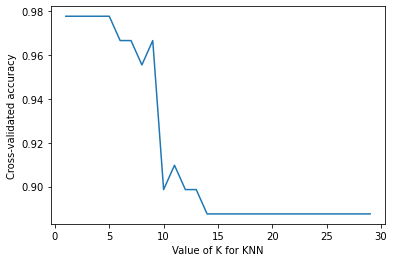

In [11]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


# Number of k from 1 to 30
k_range = range(1, 30)
k_scores = []
# Calculate cross validation score for every k number from 1 to 30
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
# It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

# Plot accuracy for every k number between 1 and 30
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [12]:
# K-Nearest Neighbors
# I decided to go with k=5 since one of the highest accuracy obtained with it
# Train the model and predict for k=5

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test, y_pred))

# classification report for test set
print(metrics.classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with 'accuracy' scoring and 10 folds
accuracy = cross_val_score(knn, X, y, scoring = 'accuracy',cv=10)
print('cross validation score (accuracy)=',accuracy.mean())

# Calculate cv score with 'roc_auc_ovr' scoring and 10 folds
accuracy = cross_val_score(knn, X, y, scoring = 'roc_auc_ovr',cv=10)
print('cross validation score with roc_auc=',accuracy.mean())


[[21  0]
 [ 1  1]]
              precision    recall  f1-score   support

           0      0.955     1.000     0.977        21
           1      1.000     0.500     0.667         2

    accuracy                          0.957        23
   macro avg      0.977     0.750     0.822        23
weighted avg      0.958     0.957     0.950        23

cross validation score (accuracy)= 0.9742424242424242
cross validation score with roc_auc= 0.9400000000000001


C:\Users\acer.LAPTOP-OODPR6CI\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


[[21  0]
 [ 1  1]]
              precision    recall  f1-score   support

           0      0.955     1.000     0.977        21
           1      1.000     0.500     0.667         2

    accuracy                          0.957        23
   macro avg      0.977     0.750     0.822        23
weighted avg      0.958     0.957     0.950        23

cross validation score (accuracy)= 0.9742424242424242
cross validation score with roc_auc= 0.9400000000000001


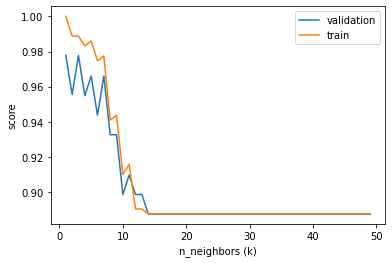

In [13]:
# K-Nearest Neighbors but with validation
from sklearn.model_selection import validation_curve

model = KNeighborsClassifier(n_neighbors=5)
k = np.arange(1, 50)

train_score, val_score = validation_curve(model, X_train, y_train,
                                          'n_neighbors', k, cv=5)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
# classification report for test set
print(metrics.classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with 'accuracy' scoring and 10 folds
accuracy = cross_val_score(knn, X, y, scoring = 'accuracy',cv=10)
print('cross validation score (accuracy)=',accuracy.mean())

# Calculate cv score with 'roc_auc_ovr' scoring and 10 folds
accuracy = cross_val_score(knn, X, y, scoring = 'roc_auc_ovr',cv=10)
print('cross validation score with roc_auc=',accuracy.mean())

plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors (k)')
plt.legend()

In [14]:
#K-Nearest Neighbors :GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 30),
              'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
model.score(X_test, y_test)

0.9888888888888889
{'metric': 'manhattan', 'n_neighbors': 1}


0.9565217391304348

In [15]:
# Random Forest: GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Train and fit the Random Forest Classification model
forest = RandomForestClassifier(n_estimators=100,random_state = 0)

# GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 10)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_estimator_)
y_pred = CV_rfc.predict(X_test)

print(confusion_matrix(y_test, y_pred))
# Classification report
print(metrics.classification_report(y_test, y_pred.round(), digits=3))
# Calculate cv score with 'roc_auc_ovr' scoring and 10 folds
accuracy = cross_val_score(forest, X, y,scoring = 'roc_auc_ovr',cv=10)
print('cross validation score with roc_auc_ovr scoring=',accuracy.mean())

# Calculate roc_auc score
print('roc_auc_score=',roc_auc_score(y_test,CV_rfc.predict_proba(X_test)[:, 1]))

RandomForestClassifier(random_state=0)
[[21  0]
 [ 1  1]]
              precision    recall  f1-score   support

           0      0.955     1.000     0.977        21
           1      1.000     0.500     0.667         2

    accuracy                          0.957        23
   macro avg      0.977     0.750     0.822        23
weighted avg      0.958     0.957     0.950        23

cross validation score with roc_auc_ovr scoring= 0.915
roc_auc_score= 1.0


In [17]:
#############
# Conclusion:
# We find that with 'Random Forest: GridSearchCV', the scores ares highest
#      cross validation score with roc_auc_ovr scoring= 0.915
#      roc_auc_score= 1.0
#############